1. DBSCAN noise points have label -1, so I remove all the -1 noise samples.   
Checking the PCA loading coefficients to interpret what each PC represents is indeed convenient, but in reality many small features in a PC cannot be directly linked to style. So at the moment, I can only rely on plotting the PCs and deducing what style the two ends of each PC correspond to.

2. Plot PC1 and PC2.
Use known players to judge what styles the axes correspond to + examine the main contributing features of these two axes.
I want to use Plotly here so the points are interactive and verifiable.

3. Plot PC3 and PC4.
Again, use known players to infer the styles + look at their contributing features.

4. Pseudo-labels:
Assign labels to players who are extreme on PC1/PC2, and then train multiple classifiers.

5. Feed the noise points from Step 1 (i.e., the ordinary players) into these classifiers to obtain multi-dimensional probability values.

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
df = pd.read_csv('player_features.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2695 entries, 0 to 2694
Data columns (total 73 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 2695 non-null   int64  
 1   user                       2695 non-null   object 
 2   CenterControlScore         2695 non-null   float64
 3   PieceActivityScore         2695 non-null   float64
 4   KingSafetyScore            2695 non-null   float64
 5   CastlingScore              2695 non-null   float64
 6   KingTropismScore           2695 non-null   float64
 7   KingDefendersScore         2695 non-null   float64
 8   KingPawnShieldScore        2695 non-null   float64
 9   KingZoneControlScore       2695 non-null   float64
 10  KingDiagonalExposureScore  2695 non-null   float64
 11  KingEscapeSquaresScore     2695 non-null   float64
 12  CaptureRatio               2695 non-null   float64
 13  PawnCenter                 2695 non-null   float

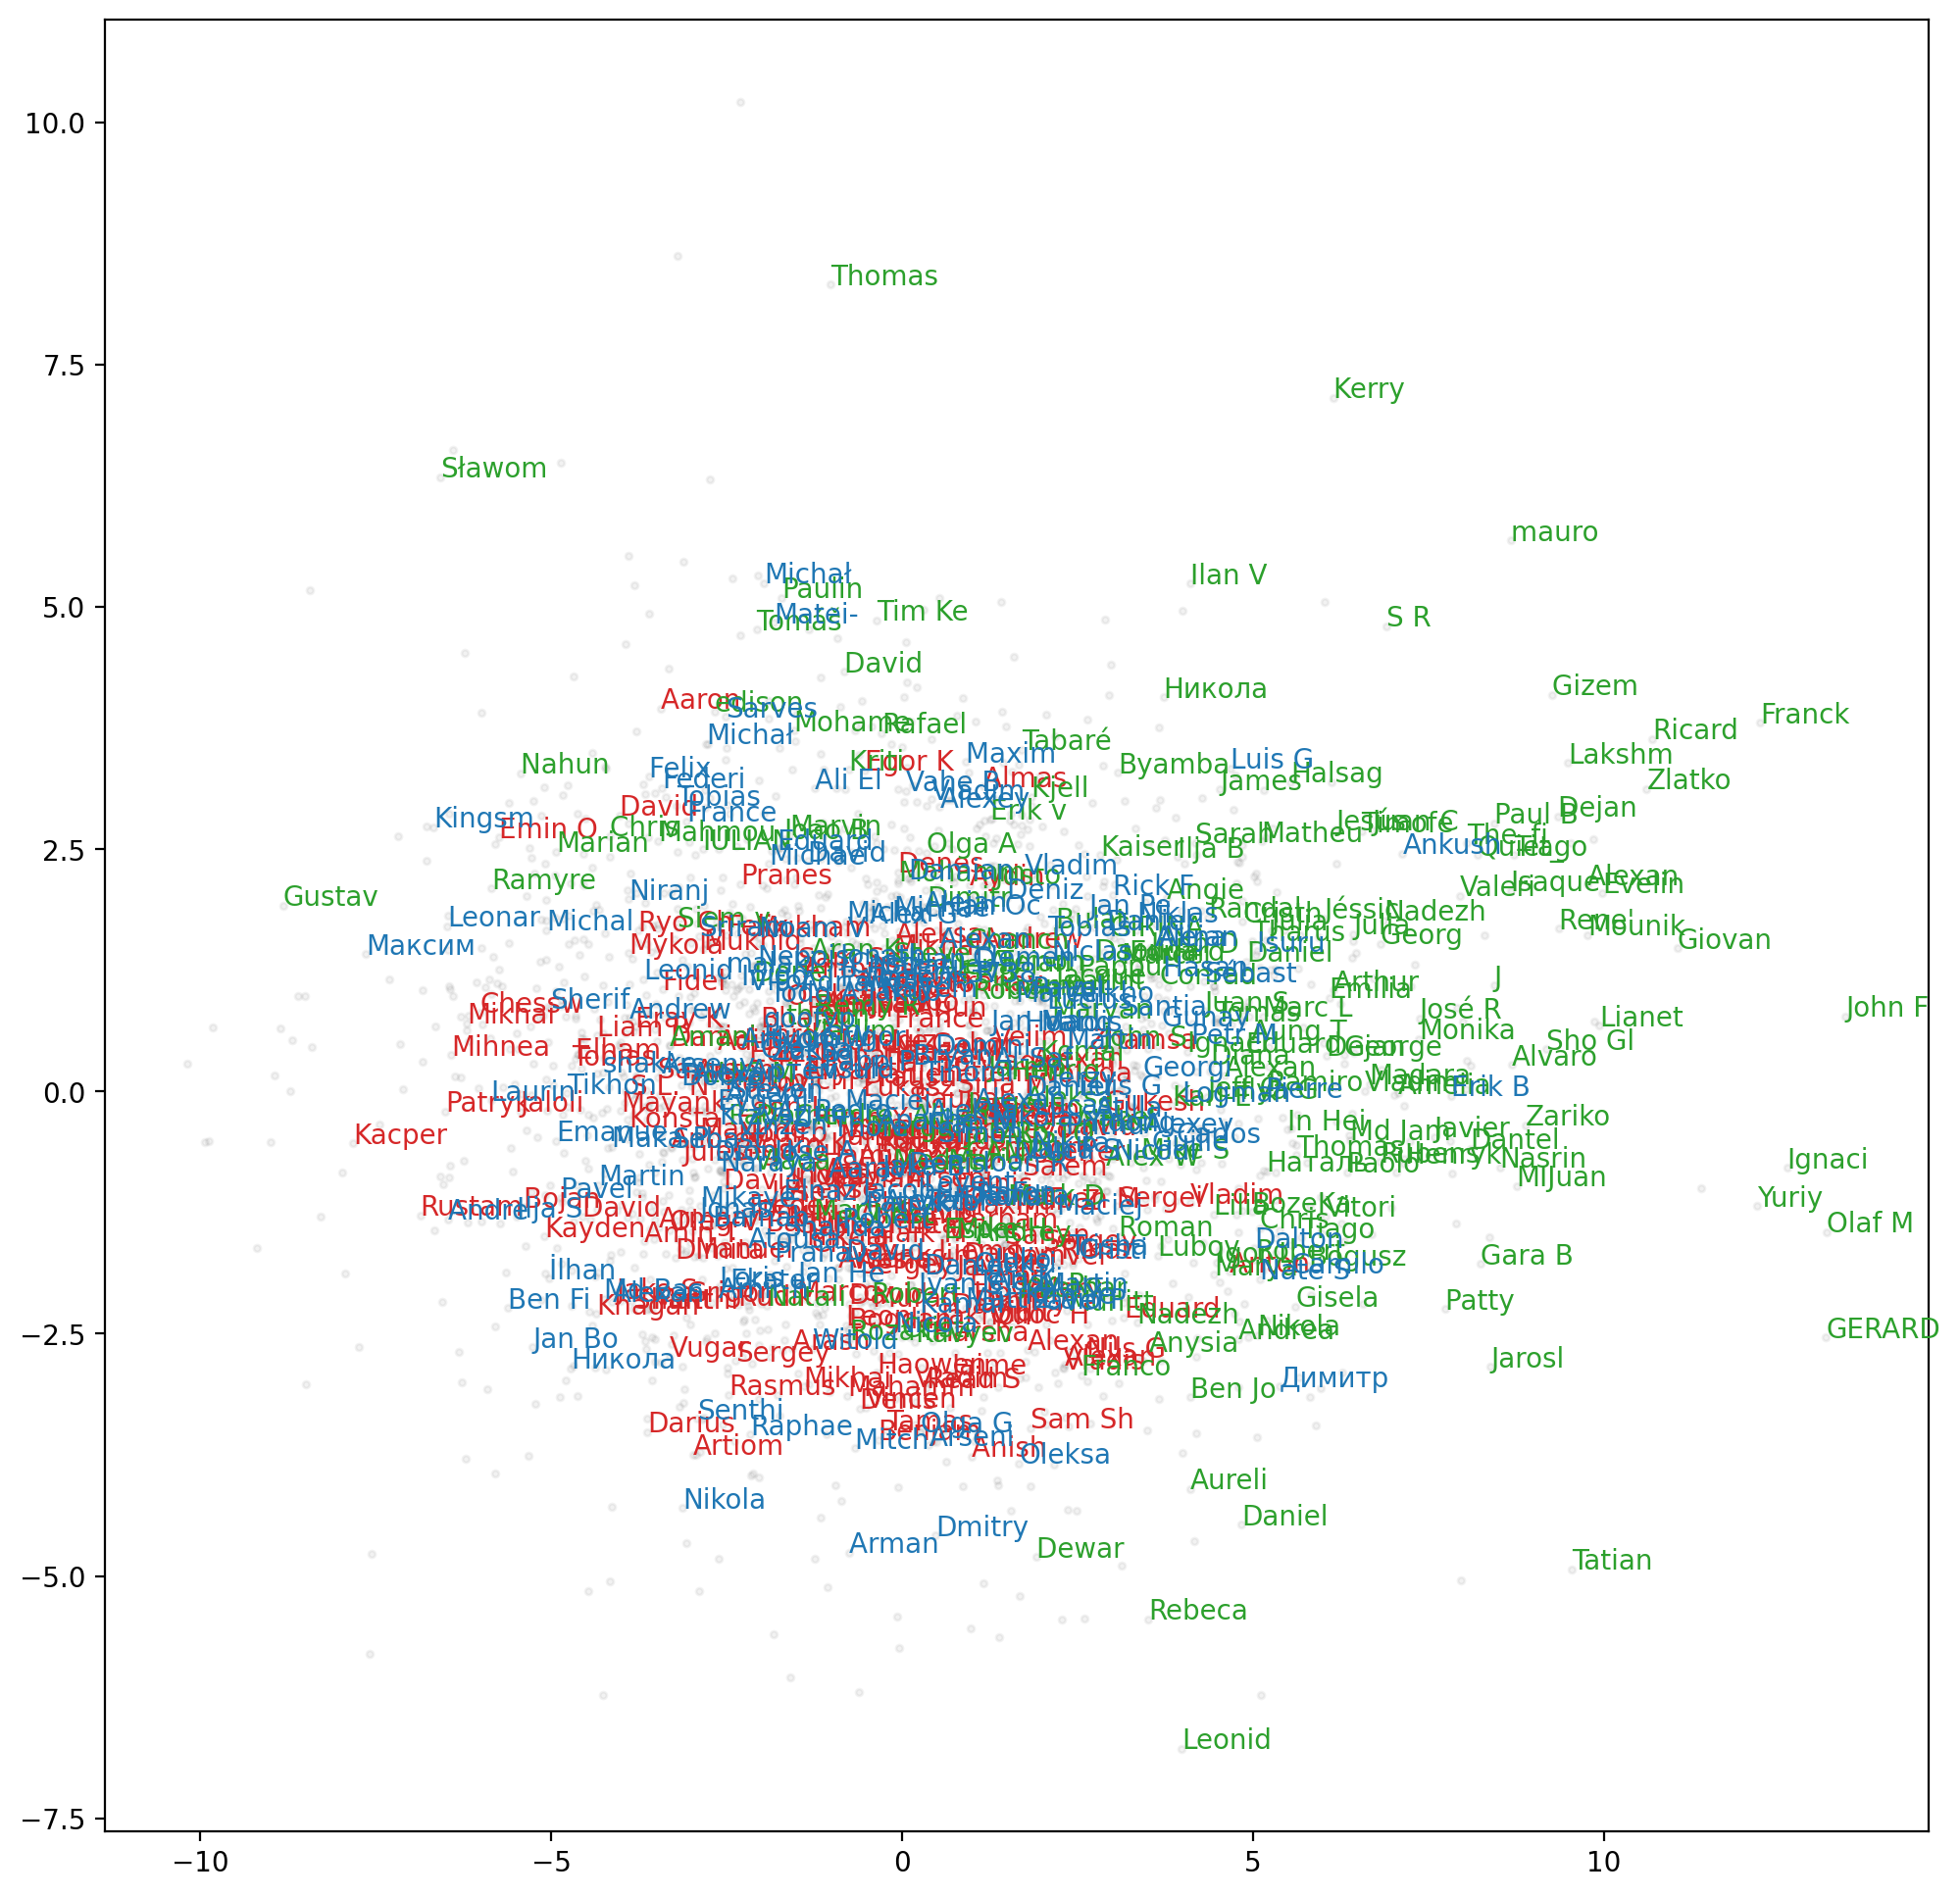

In [3]:
#把所有数字特征都扔到了pca里
cols=list(df.columns[2:20])+list(df.columns[24:47])  #除去了非皇后的升变
df_filt = df[df.TotalGames > 100][cols].fillna(0).reset_index(drop=True)
# Create the pipeline
pca_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2))
])

# Fit the pipeline and transform the data
X_pca = pca_pipeline.fit_transform(df_filt.values)
num_chosen = 200
lowest_players = df.sort_values(by='ELO').Name[0:num_chosen].values
highest_players = df.sort_values(by='ELO', ascending=False).Name[0:num_chosen].values
medium_players = df.sort_values(by='ELO', ascending=False).Name[int(len(df)/2):int(len(df)/2)+num_chosen].values

plt.figure(figsize=(12,12))
for name in highest_players:
    df_sel = df.reset_index()
    my_id = df_sel[df_sel.user==name].index[0]
    my_name = df_sel[df_sel.user==name].user.values[0]
    plt.text(X_pca[:,0][my_id], X_pca[:,1][my_id], my_name[0:6], c='C3')

for name in lowest_players:
    df_sel = df.reset_index()
    my_id = df_sel[df_sel.user==name].index[0]
    my_name = df_sel[df_sel.user==name].user.values[0]
    plt.text(X_pca[:,0][my_id], X_pca[:,1][my_id], my_name[0:6], c='C2')

for name in medium_players:
    df_sel = df.reset_index()
    my_id = df_sel[df_sel.user==name].index[0]
    my_name = df_sel[df_sel.user==name].user.values[0]
    plt.text(X_pca[:,0][my_id], X_pca[:,1][my_id], my_name[0:6], c='C0')


plt.plot(X_pca[:,0], X_pca[:,1], 'o', alpha=0.05, c='k', ms=2.5)

use DBSCAN to filter out the green noise part

In [ ]:
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import numpy as np
import plotly.express as px


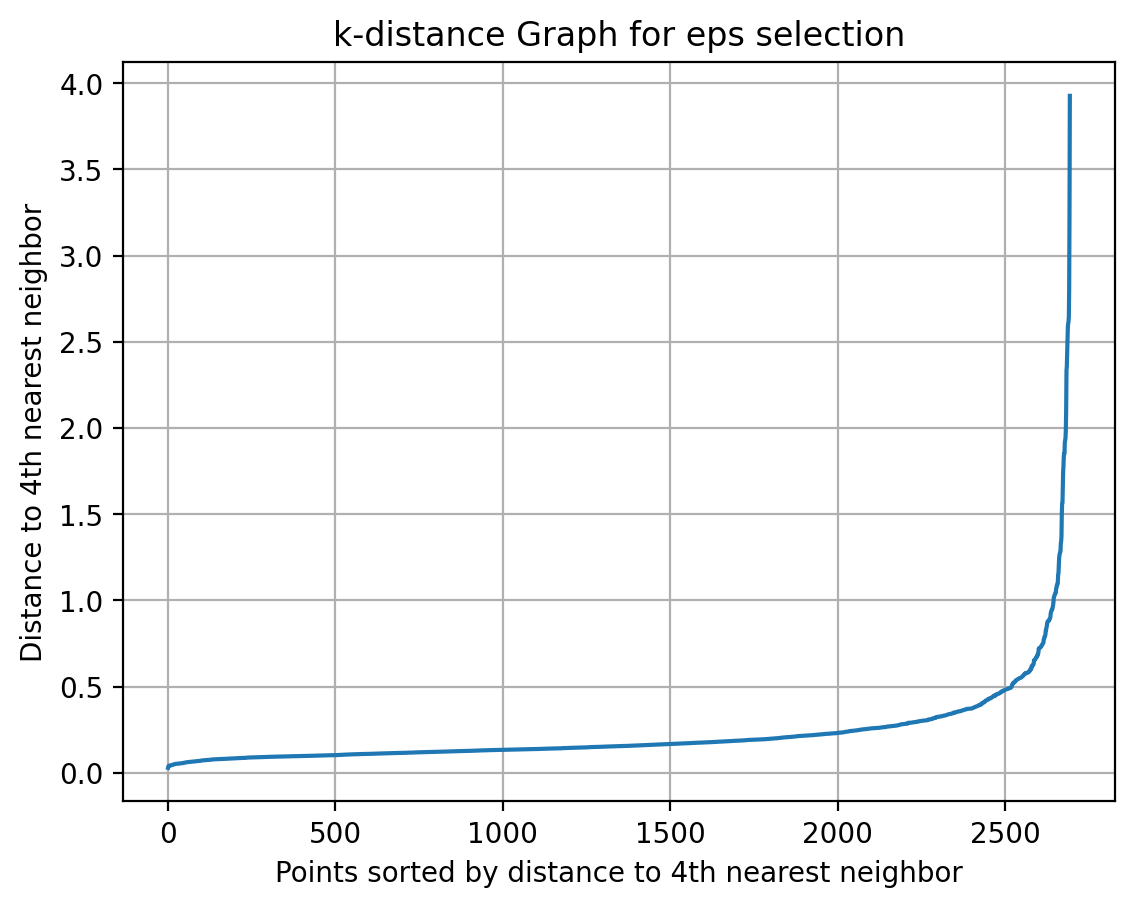

In [5]:
neighbors=NearestNeighbors(n_neighbors=20) #可能还要改
neighbors_fit=neighbors.fit(X_pca)
distance,indices=neighbors_fit.kneighbors(X_pca)
distance=np.sort(distance[:,3])
plt.plot(distance)
plt.xlabel('Points sorted by distance to 4th nearest neighbor')
plt.ylabel('Distance to 4th nearest neighbor')
plt.title('k-distance Graph for eps selection')
plt.grid(True)
plt.show()
#eps选择大概0.5这样

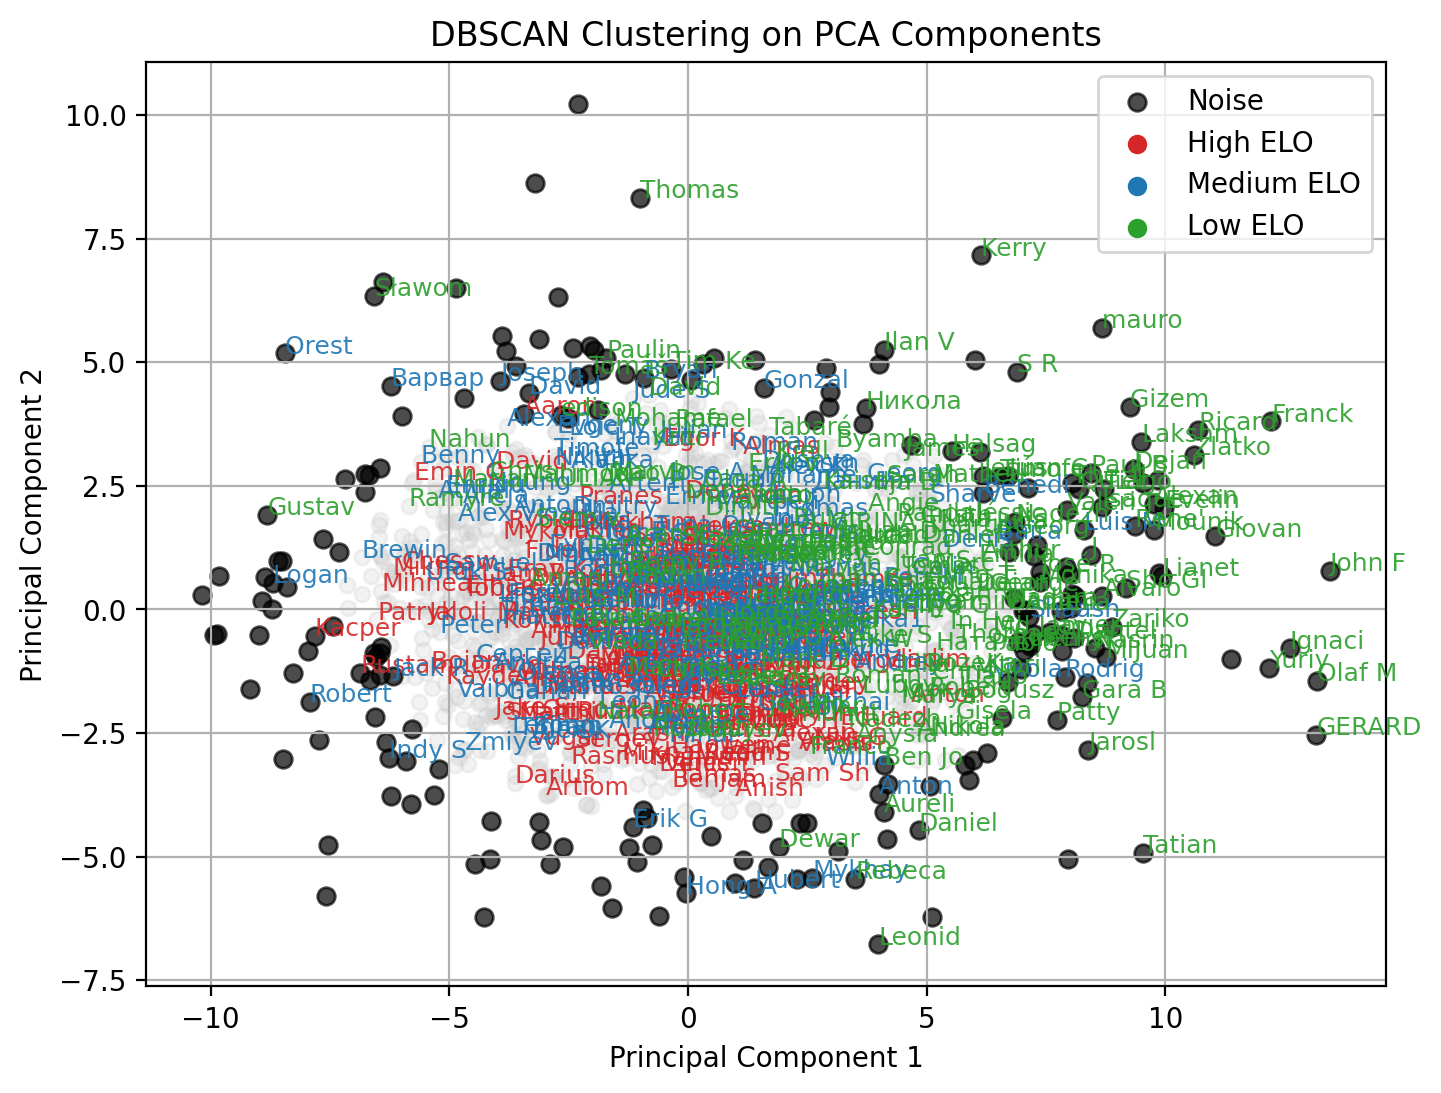

In [6]:
dbscan=DBSCAN(eps=0.8,min_samples=20)
#让噪声点变多：减小eps，增加min_samples
labels=dbscan.fit_predict(X_pca)
plt.figure(figsize=(8,6))
unique_labels=set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
df_sorted = df.sort_values(by='ELO')
lowest_players  = df_sorted.head(num_chosen).Name.values
highest_players = df_sorted.tail(num_chosen).Name.values
medium_players  = df_sorted.iloc[len(df)//2 : len(df)//2 + num_chosen].Name.values

df_sel = df.reset_index()  # 为了通过名字找到行号

for k in set(labels):
    mask = (labels == k)
    if k == -1:
        # Noise: 黑色
        plt.scatter(X_pca[mask,0], X_pca[mask,1], c='k', s=40, alpha=0.7, label='Noise')
    else:
        # 非噪声 cluster：统一浅灰色
        plt.scatter(X_pca[mask,0], X_pca[mask,1], c='#CCCCCC', s=30, alpha=0.25)

def plot_player_group(player_list, color, label):
    for name in player_list:
        if name not in df_sel.user.values:
            continue
        idx = df_sel[df_sel.user == name].index[0]
        plt.text(
            X_pca[idx, 0], X_pca[idx, 1], name[:6],
            color=color, fontsize=9, alpha=0.9
        )
    plt.scatter([], [], color=color, label=label)  # legend entry

plot_player_group(highest_players, 'C3', 'High ELO')
plot_player_group(medium_players, 'C0', 'Medium ELO')
plot_player_group(lowest_players, 'C2', 'Low ELO')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering on PCA Components')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#获得这些噪声具体是谁，即noise_players里的人
noise_indices=np.where(labels==-1)[0]
#把噪音里的高水平玩家排除掉，不记为噪音
highest_players_names=df_sorted.tail(num_chosen).Name.values
highest_players_indices = df[df['Name'].isin(highest_players_names)].index.values
noise_indices = [idx for idx in noise_indices if idx not in highest_players_indices]
noise_players=df.iloc[noise_indices][['Name','ELO']]

for index, row in noise_players.iterrows():
    print(row['Name'], row['ELO'])
print(f'rows:{noise_players.shape[0]},columns:{noise_players.shape[1]}')

Adam Collins 2540.0
Adrian Antonio Garcia Garcia 2531.0
Albert Fishman 2304.0
Aleksander Kumala 2553.0
Aleksandr Ivanov 2339.0
Alexander Khlebovich 2906.0
Alexander Spichkin 2413.0
Alexandra Prado 1791.0
Alfeu Junior Varela Bueno 2432.0
Alvaro Donatti 2205.0
Amelia Hernandez 2230.0
Ana Kuchava 2304.0
Anastasios Mihailidis 2520.0
Andre Bold 2578.0
Andrés Delgado 2429.0
Ankush Khandelwal 2560.0
Anton Barash 2448.0
Anton Isajevsky 2626.0
Arman Ghevondyan 2561.0
Artem Gulevich 2462.0
Arthur Muromtsev 2318.0
Aurelio Vila Dupla 2167.0
Austin Mei 2665.0
Ben Johnson 2148.0
Benedikt Huber 2613.0
Benik Agasarov 2806.0
Brett Passen 2461.0
Bryan Weisz 2625.0
Carlos Andres Perdomo 2764.0
Cedric Chassard 2303.0
Christos Krallis 2804.0
Cyrielle Monpeurt 2246.0
César Augusto Blanco Gramajo 2348.0
Daniel Kopylov 2757.0
Daniel Marcolino 2112.0
Dantelle Joubert 2056.0
David Levine 2285.0
David Zhurbinsky 2636.0
Dejan Jakovljevic 1949.0
Denis Kovalev 2775.0
Dewar B. Feliz Dotel 2204.0
Djuro Skaric 2431.0


In [29]:
#df_interpretate打算用来放排除掉噪音点和较差劲玩家的数据
df_interpretate=df.copy()
print(df.shape[0],df.shape[1])
df_interpretate=df_interpretate.drop(noise_indices)
print(df_interpretate.shape[0],df_interpretate.shape[1])
#输出结果正确，刚好差215行
#df_interpretate=df_interpretate[df_interpretate.TotalGames > 100][cols].fillna(0).reset_index(drop=True)
#print(df_interpretate.shape[0],df_interpretate.shape[1])

2695 73
2480 73


In [30]:
print(df['ELO'].describe())
print((df['ELO']>2800).value_counts())  #这个可以调的，选的顶级棋手，免得其实不咋厉害的人反而子维度分很高
df_interpretate=df_interpretate[df_interpretate['ELO']>2800].copy()

count    2695.000000
mean     2607.291280
std       253.227287
min      1533.000000
25%      2452.000000
50%      2604.000000
75%      2777.000000
max      3319.000000
Name: ELO, dtype: float64
ELO
False    2084
True      611
Name: count, dtype: int64


In [31]:
df_interpretate

,Unnamed: 0,user,CenterControlScore,PieceActivityScore,KingSafetyScore,CastlingScore,KingTropismScore,KingDefendersScore,KingPawnShieldScore,KingZoneControlScore,...,knight_promo_1LifeRatio,knight_promo_2LifeRatio,knight_promo_3LifeRatio,knight_promo_4LifeRatio,knight_promo_5LifeRatio,knight_promo_6LifeRatio,knight_promo_7LifeRatio,knight_promo_8LifeRatio,Name,ELO
8,8,Aarav Dengla,19.209783,180.296415,-65.166770,-14.679706,-12.125795,3.997592,-6.607544,-37.933056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aarav Dengla,2871.0
14,14,Aaron Jacobson,19.088649,181.048842,-63.112886,-14.650555,-12.029564,3.997822,-6.119282,-35.911994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Jacobson,3062.0
16,16,Aaron Mendes,18.472867,174.405827,-67.255407,-15.065344,-12.702657,3.988298,-6.061885,-38.943117,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron Mendes,2804.0
18,18,Abdulla Gadimbayli,19.451422,180.624069,-57.768043,-15.399012,-11.036538,3.989739,-5.001580,-32.171562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abdulla Gadimbayli,2831.0
19,19,Abhimanyu Puranik,19.977295,185.669041,-61.359994,-15.663233,-11.778670,3.998009,-5.632430,-33.909694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abhimanyu Puranik,2989.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647,2647,Валерий Свиридов,19.486391,175.430781,-60.143010,-16.747749,-11.375693,3.997822,-6.559545,-31.766261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валерий Свиридов,2933.0
2675,2675,Николай Гриценко,19.430324,178.214115,-57.852804,-14.935397,-11.360097,3.992435,-5.978624,-31.784048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Николай Гриценко,2801.0
2681,2681,Рамиль Садыков,19.714544,182.782246,-59.660921,-14.625455,-11.704661,3.983125,-6.019569,-33.570513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Рамиль Садыков,2934.0
2689,2689,Шубин Кирилл,20.728763,191.101687,-57.803638,-15.231112,-11.560297,3.998373,-5.710813,-31.163617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Шубин Кирилл,2944.0


对这些顶级棋手聚类，尝试解释风格

In [33]:
df_interpretate_flit=df_interpretate[df_interpretate.TotalGames>100][cols].fillna(0).reset_index(drop=True)
interpretate_X_pca = pca_pipeline.fit_transform(df_interpretate_flit.values)

In [42]:
df_interpretate_pca = pd.DataFrame({
    "PC1": interpretate_X_pca[:, 0],
    "PC2": interpretate_X_pca[:, 1],
    "Name": df_interpretate.user.values
})

top_highest_players = df_sorted.tail(20).Name.values
#选top玩家
df_interpretate_pca["is_top"] = df_interpretate_pca["Name"].isin(top_highest_players)
#只有top玩家显示文字，其他玩家为空
df_interpretate_pca["text"] = df_interpretate_pca["Name"].where(df_interpretate_pca["is_top"], "")

fig = px.scatter(
    df_interpretate_pca,
    x="PC1",
    y="PC2",
    color="is_top",
    text="text",          #只显示 top 的名字
    hover_name="Name",    #其他一般的玩家只有悬停的时候才显示名字
    opacity=0.6
)
fig.update_traces(textposition="top center")
fig.update_layout(
    width=1200,
    height=900,
    showlegend=False,
    title="Interactive PCA Scatter Plot (Plotly)"
)

fig.update_xaxes(zeroline=True, zerolinewidth=1,zerolinecolor='red')
fig.update_yaxes(zeroline=True, zerolinewidth=1,zerolinecolor='red')

fig.show()

### ♟️ PCA Visualization: Titled Tuesday Player Styles

This visualization accurately segments top-tier chess styles. Even without knowing the input features, the player distribution reveals the hidden meaning of the axes.

---

#### 1. The Axes: Defining the Spectrum

* **Y-Axis: Risk Appetite**
    * **⬆️ Top (Chaos/Aggression):** Radical, tactical complications, "all-or-nothing."
        * *Examples:* Bortnyk, Hans Niemann.
    * **⬇️ Bottom (Solid/Control):** Risk-averse, defensive mastery, squeeze technique.
        * *Examples:* Wesley So, Andreikin, Magnus Carlsen.

* **X-Axis: Strategic Approach**
    * **⬅️ Left (Academic/Theoretical):** "The Correct Move," engine preparation, deep opening theory.
        * *Examples:* MVL, Aleksei Sarana, Wesley So.
    * **➡️ Right (Street Fighter/Intuitive):** "The Tricky Move," unorthodox systems, psychological warfare.
        * *Examples:* Tuan Minh Le, Firouzja, Nakamura.

---

#### 2. The Four "Player Personas" (Quadrants)

| Quadrant | Type | Description | Key Players |
| :--- | :--- | :--- | :--- |
| **Top-Right** | **The Tactical Beasts** | **Aggressive + Intuitive.** Dangerous in time scrambles; fast & complex play. Prone to over-pushing. | *Firouzja, Pragg, Movahed* |
| **Bottom-Right** | **The Tricky Grinders** | **Solid + Unorthodox.** They avoid main lines, drag you into strange positions, and outplay you in the endgame. | *Andreikin, Sindarov, Maghsoodloo* |
| **Bottom-Left** | **The Iron Machines** | **Solid + Theoretical.** The "Truth" seekers. Extremely hard to beat; almost zero mistakes. | *Wesley So, Magnus, MVL, Nihal* |
| **Top-Left** | **The Sharp Theoreticians** | **Aggressive + Prepared.** They utilize deep, computer-prepared gambits and sharp lines. | *Bortnyk, Ediz Gurel, Sarana* |

---

#### 3. Key Player Insights

* **Hikaru Nakamura (Center-Right):**
    * He sits near the center (slightly right/down). He combines Firouzja's trickery with Andreikin's resilience. This balance is why he is the *King of Titled Tuesday*.

* **Magnus Carlsen (Bottom-Left):**
    * Surprisingly "Solid." In Blitz, he relies on fundamental superiority and endgame technique ("The Squeeze") rather than chaotic tactics.

* **Tuan Minh Le (Far Right):**
    * The ultimate outlier. The definition of "Street Chess"—he maximizes practical chances and traps over objective correctness.

---

# 1.Chaos binary classification 
Positive samples: players at Y-axis's top   
Negetive samples: players at Y-axis's bottom    

In [51]:
#get the name lists of positive players abnd negetive players
#use 10% of people to make the classifer to learn
percent_10 = int(len(df_interpretate_pca) *0.1)
print(percent_10)
#positive samples
# 按 y 轴从高到低排序
chaos_positive_players = df_interpretate_pca.sort_values("PC2", ascending=False).head(percent_10)
# 只要名字
chaos_positive_names = chaos_positive_players["Name"].tolist()
print(chaos_positive_names)

#negetive samples
chaos_negetive_players=df_interpretate_pca.sort_values('PC2',ascending=True).head(percent_10)
chaos_negetive_names=chaos_negetive_players['Name'].tolist()
print(chaos_negetive_names)

59
['Thomas Beerdsen', 'Aaron Jacobson', 'Sebastian Mihajlov', 'Deniel Safarov', 'Egor Koshulyan', 'Almas Rakhmatullaev', 'Arthur De Winter', 'Dachey Lin', 'Johan-Sebastian Christiansen', 'Zachary Tanenbaum', 'Sahaj Grover', 'Anthony Atanasov', 'Klementy Sychev', 'David Gavrilescu', 'Silvius Tiberius', 'Satria Duta Cahaya', 'Artem Dyachuk', 'Nitin Senthilvel', 'Denes Boros', 'Daniel Chan', 'Levy Rozman', 'Leo Valle Luis', 'Dominik Horvath', 'Ilamparthi A R', 'Lucas Do Valle Cardoso', 'Maksim Ivannikov', 'Aydin Suleymanli', 'Ian Dzhumagaliev', 'Krzysztof Jakubowski', 'Kiborg95', 'Alexei Shirov', 'Francisco Javier Muñoz', 'Shahruh Turayev', 'Maxim Lugovskoy', 'Ilyass Msellek', 'Gevorg Harutjunyan', 'Vadym Petrovskyi', 'Adar TARHAN', 'Matvey Galchenko', 'Seyed Abolfazl Moosavifar', 'Pranesh M', 'Nikolozi Kacharava', 'Alexander Velikanov', 'Owen McCoy', 'Emin Ohanyan', 'Kirill Alekseenko', 'Abdulla Gadimbayli', 'Floryan Eugene', 'Mikhail Antipov', 'Sravan Renjith', 'Maciej Klekowski', 'Far

In [ ]:
chaos_1_players= df[df["user"].isin(chaos_positive_names)]
chaos_0_players=df[df['user'].isin(chaos_negetive_names)]

only 59 positive samples and 59 negetive samples,   
try to get more samples from these players' raw game table: kingsafety&lifespan

In [59]:
#1. Filter out short games : moves<20  
#2. Mini-batch : Aggregation 10 games' average  
import sqlite3
db_file=r"C:\sqlite3\chess.db"
conn=sqlite3.connect(db_file)
table1='lifespan'
playercolumn1='player'
chaos_1_holders = ",".join(["?"] * len(chaos_positive_names))
query = f"""
SELECT *
FROM {table1}
WHERE {playercolumn1} IN ({chaos_1_holders})
"""
chaos_1_lifespan_all = pd.read_sql(query, conn, params=chaos_positive_names)
chaos_1_lifespan_all

,uid,player,king_1Span,king_1LifeRatio,queen_1Span,queen_1LifeRatio,rook_1Span,rook_1LifeRatio,rook_2Span,rook_2LifeRatio,...,knight_promo_4Span,knight_promo_4LifeRatio,knight_promo_5Span,knight_promo_5LifeRatio,knight_promo_6Span,knight_promo_6LifeRatio,knight_promo_7Span,knight_promo_7LifeRatio,knight_promo_8Span,knight_promo_8LifeRatio
0,20,Pranesh M,"(0, 49)",1.0,"(0, 49)",1.0,"(0, 25)",0.5102040816326531,"(0, 49)",1.0,...,None,None,None,None,None,None,None,None,None,None
1,29,Ilyass Msellek,"(0, 54)",1.0,"(0, 54)",1.0,"(0, 54)",1.0,"(0, 50)",0.925925925925926,...,None,None,None,None,None,None,None,None,None,None
2,32,Klementy Sychev,"(0, 56)",1.0,"(0, 56)",1.0,"(0, 56)",1.0,"(0, 56)",1.0,...,None,None,None,None,None,None,None,None,None,None
3,56,Johan-Sebastian Christiansen,"(0, 87)",1.0,"(0, 22)",0.2528735632183908,"(0, 87)",1.0,"(0, 74)",0.8505747126436781,...,None,None,None,None,None,None,None,None,None,None
4,68,Levy Rozman,"(0, 44)",1.0,"(0, 44)",1.0,"(0, 44)",1.0,"(0, 44)",1.0,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36807,1017268,Gevorg Harutjunyan,"(0, 99)",1.0,"(0, 66)",0.6666666666666666,"(0, 99)",1.0,"(0, 64)",0.6464646464646465,...,None,None,None,None,None,None,None,None,None,None
36808,1017498,Silvius Tiberius,"(0, 148)",1.0,"(0, 111)",0.75,"(0, 148)",1.0,"(0, 63)",0.4256756756756756,...,None,None,None,None,None,None,None,None,None,None
36809,1017518,Gevorg Harutjunyan,"(0, 152)",1.0,"(0, 35)",0.2302631578947368,"(0, 32)",0.2105263157894736,"(0, 67)",0.4407894736842105,...,None,None,None,None,None,None,None,None,None,None
36810,1017526,Gevorg Harutjunyan,"(0, 24)",1.0,"(0, 24)",1.0,"(0, 24)",1.0,"(0, 24)",1.0,...,None,None,None,None,None,None,None,None,None,None


In [60]:
chaos_0_holders = ",".join(["?"] * len(chaos_negetive_names))
query = f"""
SELECT *
FROM {table1}
WHERE {playercolumn1} IN ({chaos_0_holders})
"""
chaos_0_lifespan_all = pd.read_sql(query, conn, params=chaos_negetive_names)
chaos_0_lifespan_all

,uid,player,king_1Span,king_1LifeRatio,queen_1Span,queen_1LifeRatio,rook_1Span,rook_1LifeRatio,rook_2Span,rook_2LifeRatio,...,knight_promo_4Span,knight_promo_4LifeRatio,knight_promo_5Span,knight_promo_5LifeRatio,knight_promo_6Span,knight_promo_6LifeRatio,knight_promo_7Span,knight_promo_7LifeRatio,knight_promo_8Span,knight_promo_8LifeRatio
0,5,Alexander Donchenko,"(0, 31)",1.0,"(0, 31)",1.0,"(0, 31)",1.0,"(0, 31)",1.0,...,None,None,None,None,None,None,None,None,None,None
1,36,Shant Sargsyan,"(0, 54)",1.0,"(0, 54)",1.0,"(0, 54)",1.0,"(0, 31)",0.5740740740740741,...,None,None,None,None,None,None,None,None,None,None
2,43,Benjamin Bok,"(0, 60)",1.0,"(0, 33)",0.55,"(0, 60)",1.0,"(0, 51)",0.85,...,None,None,None,None,None,None,None,None,None,None
3,66,Mikhail Demidov,"(0, 50)",1.0,"(0, 50)",1.0,"(0, 50)",1.0,"(0, 50)",1.0,...,None,None,None,None,None,None,None,None,None,None
4,70,Bogdan Daniel Deac,"(0, 47)",1.0,"(0, 47)",1.0,"(0, 47)",1.0,"(0, 36)",0.7659574468085106,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54204,1017621,Denis Lazavik,"(0, 69)",1.0,"(0, 69)",1.0,"(0, 34)",0.4927536231884058,"(0, 53)",0.7681159420289855,...,None,None,None,None,None,None,None,None,None,None
54205,1017677,Roberto Junio Brito Molina,"(0, 119)",1.0,"(0, 23)",0.1932773109243697,"(0, 89)",0.7478991596638656,"(0, 119)",1.0,...,None,None,None,None,None,None,None,None,None,None
54206,1017690,Artem Timofeev,"(0, 117)",1.0,"(0, 82)",0.7008547008547008,"(0, 117)",1.0,"(0, 117)",1.0,...,None,None,None,None,None,None,None,None,None,None
54207,1017700,Alexander Rustemov,"(0, 137)",1.0,"(0, 21)",0.1532846715328467,"(0, 137)",1.0,"(0, 49)",0.3576642335766423,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
table2='kingsafety'
ks_cols=pd.read_sql("PRAGMA table_info(kingsafety);",conn)['name'].tolist()
ks_white_cols=['uid']+[c for c in ks_cols if c.startswith('White_')]
ks_black_cols=['uid']+[c for c in ks_cols if c.startswith('Black_')]
#positive
query_white = f"""
SELECT {", ".join(ks_white_cols)}
FROM kingsafety
WHERE White_player_id IN ({chaos_1_holders})
"""
chaos_ks_white_1=pd.read_sql(query_white,conn,params=chaos_positive_names)
query_black=f"""
SELECT {", ".join(ks_black_cols)}
FROM kingsafety
WHERE Black_player_id IN ({chaos_1_holders})
"""
chaos_ks_black_1=pd.read_sql(query_black,conn,params=chaos_positive_names)
#这里需要改一下chaos_ks_white_1和chaos_ks_black_1的列名

#df_merged = A.merge(B, left_on="a", right_on="b", how="inner")
chaos_1_ks_all=chaos_ks_white_1.merge(chaos_ks_black_1,left_on='White_player_id',right_on='Black_player_id',how='inner')
chaos_1_ks_all #结果是错的

,uid_x,White_CenterControlScoresList,White_PieceActivityScoresList,White_KingSafetyScoresList,White_CastlingScoresList,White_KingTropismScoresList,White_KingDefendersScoresList,White_KingPawnShieldScoresList,White_KingZoneControlScoresList,White_KingDiagonalExposureScoresList,...,Black_CenterControlScoreMean,Black_PieceActivityScoreMean,Black_KingSafetyScoreMean,Black_CastlingScoreMean,Black_KingTropismScoreMean,Black_KingDefendersScoreMean,Black_KingPawnShieldScoreMean,Black_KingZoneControlScoreMean,Black_KingDiagonalExposureScoreMean,Black_KingEscapeSquaresScoreMean
0,20,"[15.0, 15.0, 19.0, 22.0, 22.0, 20.0, 21.0, 21....","[129.0, 132.0, 156.0, 177.0, 180.0, 164.0, 203...","[4.4512471655328785, 4.104024943310657, -12.15...","[0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -20,...","[-8.548752834467122, -8.895975056689343, -10.1...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 15, 15, 0, 0, 0, 0, 15, 0, 0, 0, 0, 10, 1...","[0, 0, -15.0, -15.0, -15.0, -30.0, 0, 0, 0, 0,...","[-6, -6, -6, -6, -6, -6, -6, -9, -9, -9, -9, -...",...,12.298850574712644,89.19540229885058,-99.52812377824694,-17.93103448275862,-23.148813433419345,4.0,-1.0344827586206895,-67.64367816091954,-11.586206896551724,17.816091954022987
1,20,"[15.0, 15.0, 19.0, 22.0, 22.0, 20.0, 21.0, 21....","[129.0, 132.0, 156.0, 177.0, 180.0, 164.0, 203...","[4.4512471655328785, 4.104024943310657, -12.15...","[0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -20,...","[-8.548752834467122, -8.895975056689343, -10.1...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 15, 15, 0, 0, 0, 0, 15, 0, 0, 0, 0, 10, 1...","[0, 0, -15.0, -15.0, -15.0, -30.0, 0, 0, 0, 0,...","[-6, -6, -6, -6, -6, -6, -6, -9, -9, -9, -9, -...",...,20.4,229.97142857142856,-82.38952057013282,-14.857142857142858,-11.589520570132818,4.0,-8.142857142857142,-48.71428571428572,-9.942857142857145,6.857142857142857
2,20,"[15.0, 15.0, 19.0, 22.0, 22.0, 20.0, 21.0, 21....","[129.0, 132.0, 156.0, 177.0, 180.0, 164.0, 203...","[4.4512471655328785, 4.104024943310657, -12.15...","[0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -20,...","[-8.548752834467122, -8.895975056689343, -10.1...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 15, 15, 0, 0, 0, 0, 15, 0, 0, 0, 0, 10, 1...","[0, 0, -15.0, -15.0, -15.0, -30.0, 0, 0, 0, 0,...","[-6, -6, -6, -6, -6, -6, -6, -9, -9, -9, -9, -...",...,19.57894736842105,215.47368421052636,-90.85899570354458,-13.157894736842104,-23.43794307196563,4.0,-5.131578947368421,-54.73684210526316,-8.921052631578947,10.526315789473683
3,20,"[15.0, 15.0, 19.0, 22.0, 22.0, 20.0, 21.0, 21....","[129.0, 132.0, 156.0, 177.0, 180.0, 164.0, 203...","[4.4512471655328785, 4.104024943310657, -12.15...","[0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -20,...","[-8.548752834467122, -8.895975056689343, -10.1...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 15, 15, 0, 0, 0, 0, 15, 0, 0, 0, 0, 10, 1...","[0, 0, -15.0, -15.0, -15.0, -30.0, 0, 0, 0, 0,...","[-6, -6, -6, -6, -6, -6, -6, -9, -9, -9, -9, -...",...,18.466666666666665,202.2,-45.75265495086924,-14.666666666666666,-9.48598828420257,4.0,-13.5,-11.5,-10.6,10.0
4,20,"[15.0, 15.0, 19.0, 22.0, 22.0, 20.0, 21.0, 21....","[129.0, 132.0, 156.0, 177.0, 180.0, 164.0, 203...","[4.4512471655328785, 4.104024943310657, -12.15...","[0, 0, 0, 0, 0, 0, 0, -20, -20, -20, -20, -20,...","[-8.548752834467122, -8.895975056689343, -10.1...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[15, 15, 15, 0, 0, 0, 0, 15, 0, 0, 0, 0, 10, 1...","[0, 0, -15.0, -15.0, -15.0, -30.0, 0, 0, 0, 0,...","[-6, -6, -6, -6, -6, -6, -6, -9, -9, -9, -9, -...",...,16.466666666666665,137.15555555555557,-57.37637188208617,-15.555555555555555,-9.376371882086168,4.0,-4.0,-31.666666666666668,-11.333333333333334,10.555555555555555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9093337,1017542,"[13, 17.0, 20.0, 22.0, 22.0, 22.0, 22.0, 21.0,...","[148.0, 178.0, 198.0, 224.0, 218.0, 212.0, 222...","[-5.5487528344671215, -18.670975056689343, -